<div style="text-align: center;">
    <img src="../Streamlit/project_toto_logo.png" width="300" height="300">
</div>

# Project TOTO: Tornado Outbreak Threat Observations
ML Model: Developed by Michael Goodman
<https://github.com/mgoodman96>

## Problem

Iowa is known for experiencing a high number of tornado events each year. These tornadoes can cause significant damage to property and pose a threat to the safety of residents. Therefore, accurately predicting tornado events in Iowa is crucial for effective disaster preparedness and response.

While advancements in meteorological technology have improved the accuracy of tornado warnings, there are still challenges in achieving a high level of precision. One of the main challenges is the occurrence of false positives, where a tornado warning is issued but no tornado actually forms. False positives can lead to unnecessary panic and disruptions in daily life, potentially causing complacency among residents when real tornado threats arise.

The goal of this project is to develop a predictive model that can effectively identify and forecast tornado events in Iowa. By leveraging historical weather data, atmospheric conditions, and other relevant factors, we aim to improve the accuracy of tornado predictions and minimize false positives. This will enable authorities to issue timely and accurate warnings, allowing residents to take appropriate safety measures and mitigate the potential impact of tornado events.

Through this project, we hope to contribute to the ongoing efforts in enhancing tornado prediction capabilities, ultimately improving the safety and resilience of Iowa communities in the face of severe weather events.

## Assumption

<div style="display: flex; justify-content: space-between;">
    <div style="flex: 1; text-align: center;">
        <img src="images/supercell.png" alt="Supercells are assumed primary indicator" style="max-width: 80%;">
        <p> </p>
    </div>
    <br>
    <div style="flex: 1; text-align: center;margin-left: 20px;">
        <img src="images/updraft.png" alt="Warm temperature can rotate a supercell" style="max-width: 80%;">
        <p> </p>
    </div>

</div>
<center>
    <p>Source: <a href="https://scijinks.gov/tornado" target="_blank">NOAA SciJinks</a></p>
</center>


- The above diagrams explain the fundemental components of a tornado formation based on scientific studies. We will attempt to use a combination of these metrics to assign a tornado formation risk
- As Iowa is mostly topagraphically consistent, the initial risk is constant across the state. This would not be the case in larger states like Illinois or Texas. 
- Wind Shear is often not a metric included in weather APIs, we will calculate our own measure by understanding the difference in magnitude of wind vectors at different altitudes. 

- From the studies, the largest risk factor associated with tornados is not the weather itself, but the change and variation in weather. We will attempt to measure this by having various rolling average signals as independent variables


## Data Engineering

#### Location Data

Location parameters were set as the centroid of Iowa Counties. Calculated using GeoPandas on an Iowa County Shape File obtained here: 
- https://geodata.iowa.gov/datasets/iowa::iowa-county-boundaries/about



Total counties: 99
Centroid data saved to Iowa_Counties_Centroid.csv


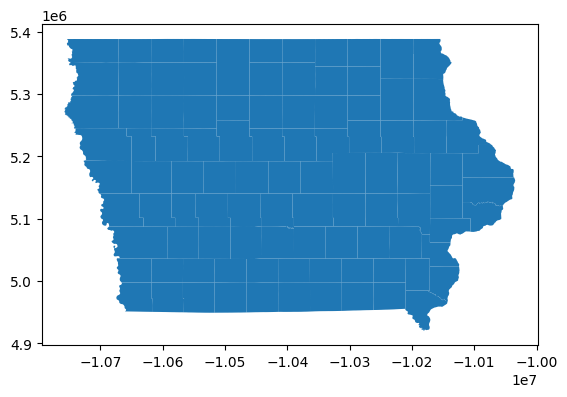

In [42]:
import geopandas as gpd

# Define the file path
shapefile_path = 'Iowa_County_Boundaries/IowaCounties.shp'

# Try reading the shapefile
try:
    gdf = gpd.read_file(shapefile_path)
    print("Total counties:", len(gdf))
    gdf.plot()
except FileNotFoundError:
    print(f"Shapefile not found at {shapefile_path}")
    exit()

# Check and convert CRS if necessary
if gdf.crs != 'epsg:4326':
    gdf = gdf.to_crs('epsg:4326')

# Re-project to a projected CRS for accurate centroid calculation
gdf = gdf.to_crs('epsg:3857')

# Calculate centroids
gdf['centroid'] = gdf.geometry.centroid

# Convert back to geographic CRS to get lat/lon
gdf = gdf.to_crs('epsg:4326')

# Extract latitude and longitude
gdf['latitude'] = gdf.centroid.y
gdf['longitude'] = gdf.centroid.x

# Select relevant columns
centroid_data = gdf[['CountyName', 'latitude', 'longitude']]

# Define the output file path
output_csv_path = 'Iowa_Counties_Centroid.csv'

# Save to CSV
centroid_data.to_csv(output_csv_path, index=False)
print(f"Centroid data saved to {output_csv_path}")


Data Model sources were obtained from two sources: 
- Iowa Weather Sensor History: 
    
    https://open-meteo.com/en/docs/historical-weather-api#location_mode=csv_coordinates 

    This is a free API that allows us to request sensor information going back 6 years (5 years of training, 1 year of test).
    To avoid API throttle limits, the GUI was used with the centroid file as our list of locations

    Data Saved at: **historical_weather_ia.csv**, due to size this is in gitignore <br><br>

    
- NOAA: National Oceanic and Atmospheric Administration

    https://www.ncdc.noaa.gov/stormevents/choosedates.jsp?statefips=19%2CIOWA#

    Storm Events database to request CSV of Tornado events in Iowa, their severity, and location from 1/1/2018 through 12/31/2023


    Data Saved at: **TornadoEvents.csv**, due to size this is in gitignore



### Data Cleaning and Joining

- Event_ID needed to be created to join Tornado events and historical data
    - County-Date-Time
    - Various cleaning and standardization needed to join
    - Tornado Binary event determined if tornado happened within +-3 hours of weather record

In [43]:
import pandas as pd
import numpy as np

# Load weather data
weather_df = pd.read_csv('historical_weather_IA.csv')

# Load county centroid data and map county names to weather data
df_counties = pd.read_csv('Iowa_Counties_Centroid.csv')
weather_df['county_name'] = weather_df['location_id'].apply(lambda x: df_counties.loc[x, 'CountyName'])
weather_df['time'] = pd.to_datetime(weather_df['time'])

# Load tornado data
df_tornado = pd.read_csv('TornadoEvents.csv')
df_tornado['CZ_NAME_STR'] = df_tornado['CZ_NAME_STR'].apply(lambda x: x.title().replace(' Co.', ''))
df_tornado['BEGIN_DATETIME'] = pd.to_datetime(df_tornado['BEGIN_DATE'] + ' ' + df_tornado['BEGIN_TIME'].apply(lambda x: str(x).zfill(4)[:2] + ':' + str(x).zfill(4)[2:]))

# Initialize the tornado column to 0
weather_df['tornado'] = 0

# Iterate over tornado events and update the tornado binary within a 3-hour window and 1 hour after
for idx, tornado_event in df_tornado.iterrows():
    tornado_time = tornado_event['BEGIN_DATETIME']
    county = tornado_event['CZ_NAME_STR']
    
    time_window_start = tornado_time - pd.Timedelta(hours=3)
    time_window_end = tornado_time + pd.Timedelta(hours=1)
    
    mask = (
        (weather_df['county_name'] == county) &
        (weather_df['time'] >= time_window_start) &
        (weather_df['time'] <= time_window_end)
    )
    
    weather_df.loc[mask, 'tornado'] = 1

In [ ]:
# Set display options for viewing
pd.set_option('display.max_columns', 500)
weather_df.head()

,location_id,time,temperature_2m,relative_humidity_2m,rain,pressure_msl,surface_pressure,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,soil_temperature_0_to_7cm,county_name,tornado
0,0,2018-01-01 00:00:00,-21.2,72,0.0,1050.5,989.6,8.1,18.0,298,305,19.1,Lyon,0
1,0,2018-01-01 01:00:00,-20.7,72,0.0,1050.7,989.9,8.1,17.8,304,310,18.9,Lyon,0
2,0,2018-01-01 02:00:00,-20.2,71,0.0,1050.5,989.8,7.5,17.2,307,314,18.8,Lyon,0
3,0,2018-01-01 03:00:00,-20.0,71,0.0,1050.6,989.9,6.9,16.3,303,314,18.6,Lyon,0
4,0,2018-01-01 04:00:00,-20.2,70,0.0,1050.8,990.1,6.3,15.5,297,311,18.5,Lyon,0


In [ ]:
#export weather_df as parquet file
weather_df.to_parquet('weather_events.parquet')

### EDA

In [22]:
#read in parquet file if not already read in
import pandas as pd
weather_df = pd.read_parquet('weather_events.parquet')

In [21]:
weather_df['tornado'].value_counts()

tornado
0    5204680
1       1136
Name: count, dtype: int64

In [27]:
#ratio of tornado events to non-tornado events
print(weather_df['tornado'].mean()*100, '% of the data is tornado events')

#weight for ML model
weight = 1 / weather_df['tornado'].mean()
print('Weight for ML model:', weight.round(2))


0.021821747061363674 % of the data is tornado events
Weight for ML model: 4582.58


70.56728247914184


<Axes: ylabel='Frequency'>

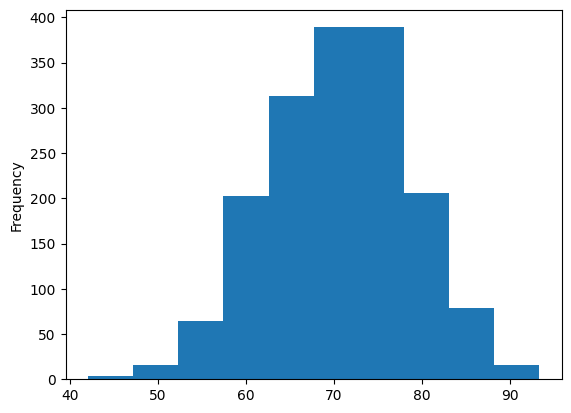

In [14]:
#show me average temperature when tornado is 1
print(weather_df[weather_df['tornado'] == 1]['temperature_2m'].mean())
#make plot of temperature when tornado is 1
weather_df[weather_df['tornado'] == 1]['temperature_2m'].plot.hist()

<Axes: ylabel='Frequency'>

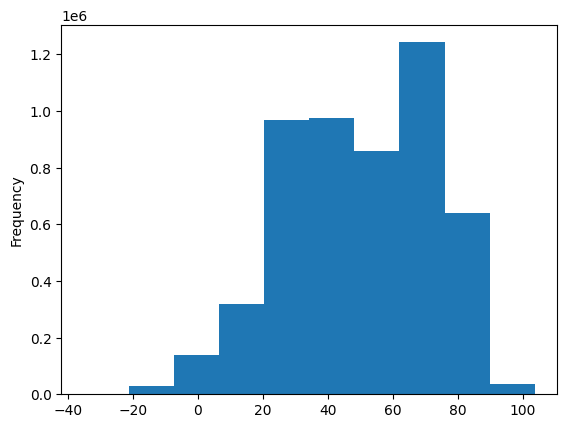

In [10]:
#plot of temperature when tornado is 0
weather_df[weather_df['tornado'] == 0]['temperature_2m'].plot.hist()

In [14]:
#pressure when tornado is 1
print(weather_df[weather_df['tornado'] == 1]['pressure_msl'].mean())

1004.0031690140846


In [15]:
#pressure when tornado is 0
print(weather_df[weather_df['tornado'] == 0]['pressure_msl'].mean())

1016.9329852747921


<Axes: ylabel='Frequency'>

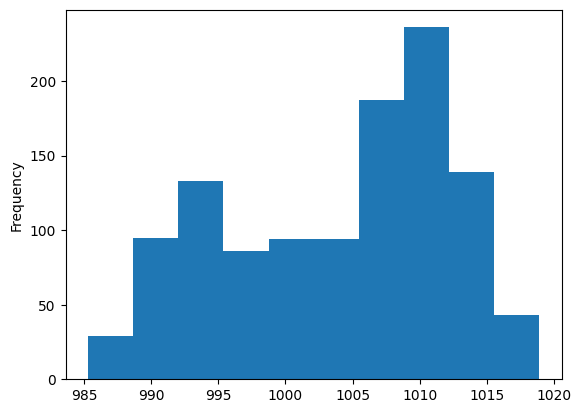

In [16]:
#histogram of pressure when tornado is 1
weather_df[weather_df['tornado'] == 1]['pressure_msl'].plot.hist()

<Axes: ylabel='Frequency'>

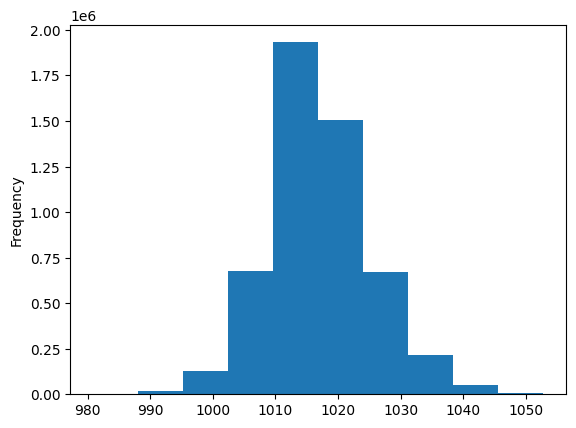

In [18]:
#hist of pressure
weather_df['pressure_msl'].plot.hist()

In [7]:
weather_df.head()

,location_id,time,temperature_2m,relative_humidity_2m,rain,pressure_msl,surface_pressure,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,soil_temperature_0_to_7cm,county_name,tornado
0,0,2018-01-01 00:00:00,-21.2,72,0.0,1050.5,989.6,8.1,18.0,298,305,19.1,Lyon,0
1,0,2018-01-01 01:00:00,-20.7,72,0.0,1050.7,989.9,8.1,17.8,304,310,18.9,Lyon,0
2,0,2018-01-01 02:00:00,-20.2,71,0.0,1050.5,989.8,7.5,17.2,307,314,18.8,Lyon,0
3,0,2018-01-01 03:00:00,-20.0,71,0.0,1050.6,989.9,6.9,16.3,303,314,18.6,Lyon,0
4,0,2018-01-01 04:00:00,-20.2,70,0.0,1050.8,990.1,6.3,15.5,297,311,18.5,Lyon,0


### Feature Engineering

As mentioned above, a tornado is formed when thunderstorms mix with wind shear creating a supercell. As the warm front mixes with the cool air it can rotate the supercell and when it touches the ground it forms a tornado. 

The weather sensor data alone does not provide enough information to predict tornado as the differences in wind speed and direction are not captured in the data table without additional calculations  

We decided to measure the magnitude of the wind shear with vector calculations and applied signals to the data to determine the change in temperature, rain, and pressure. Many of which are factors that create a thunderstorm

<div style="display: flex; justify-content: space-between;">
    <div style="flex: 1; text-align: center;">
        <img src="images/shear_calc.png" alt="" style="max-width: 25%;">
        <p> </p>
    </div>

</div>
<center>
    <p>Source: <a href="https://learningweather.psu.edu/node/93" target="_blank">Penn State Department of Meteorology</a></p>
</center>

In [23]:
import numpy as np
def calculate_wind_shear(speed1, speed2, dir1, dir2):
    # Convert wind directions from degrees to radians
    dir1_rad = np.radians(dir1)
    dir2_rad = np.radians(dir2)

    # Calculate the wind vector components at the first altitude
    u1 = speed1 * np.sin(dir1_rad)
    v1 = speed1 * np.cos(dir1_rad)

    # Calculate the wind vector components at the second altitude
    u2 = speed2 * np.sin(dir2_rad)
    v2 = speed2 * np.cos(dir2_rad)

    # Calculate the wind shear components
    shear_u = u2 - u1
    shear_v = v2 - v1

    # Calculate the magnitude of the wind shear vector
    shear_magnitude = np.sqrt(shear_u**2 + shear_v**2)
    
    return shear_magnitude

In [44]:
weather_df['wind_shear'] = weather_df.apply(lambda x: calculate_wind_shear(x['wind_speed_10m'], x['wind_speed_100m'], x['wind_direction_10m'], x['wind_direction_100m']), axis=1)

<Axes: ylabel='Frequency'>

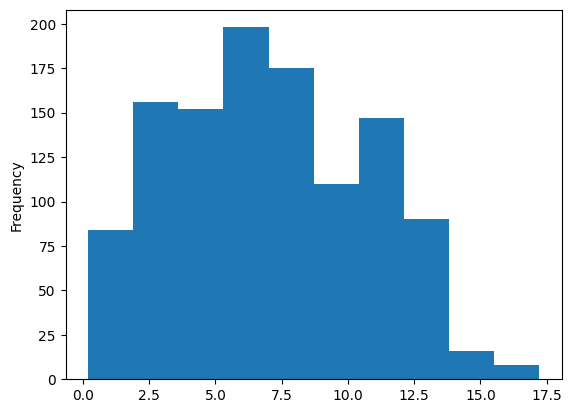

In [24]:
#histogram of wind shear when tornado is 1
weather_df[weather_df['tornado'] == 1]['wind_shear'].plot.hist()


<Axes: ylabel='Frequency'>

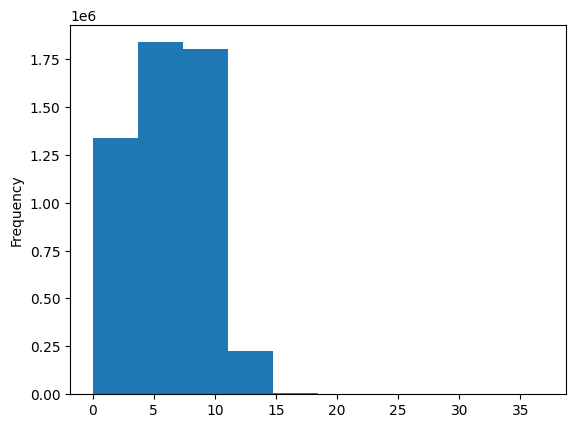

In [23]:

#histogram of wind shear when tornado is 0
weather_df[weather_df['tornado'] == 0]['wind_shear'].plot.hist()


In [25]:
#round wind shear to 2 decimal places
weather_df['wind_shear'] = weather_df['wind_shear'].round(2)

In [26]:
weather_df.to_parquet('weather_events.parquet')

## Model Approach

### Import Libraries

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from xgboost import XGBClassifier
#feature importance
import matplotlib.pyplot as plt
from xgboost import plot_importance

from catboost import CatBoostClassifier

### Class Imbalance
Due to tornados being signifantly rare events, there is a high imbalance between our target variable. In most ML libraries, this can be addressed through a target weight parameter that is defined as Count(Negative_targets)/Count(Positive Targets)

In [46]:
weight=weather_df['tornado'].value_counts()[0]/weather_df['tornado'].value_counts()[1]
weight

4581.584507042254

### Split Train Test Set

In [47]:
X = weather_df.drop(columns=['tornado', 'time','county_name', 'location_id'])
y = weather_df['tornado']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=96)

### XGBoost
xgb was decided to be the starting point due to its benefit in highly imbalanced data. We started with the defualt learning rate and depth, and adjusted the weight parameter

F1 weighted was our metric used to assess performance as tornado warnings are binary

The feature importance was used to see how our intial model lined up to the domain knowledge explained above

In [48]:
#xgboost model initial
#import f1 score weighted
from sklearn.metrics import f1_score

#initial xgboost model
from xgboost import XGBClassifier
#use weight for imbalanced data
model = XGBClassifier(scale_pos_weight=weight)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

print("Weighted F1 Score: %.2f%%" % (weighted_f1 * 100.0))

#confusion matrix
confusion_matrix(y_test, y_pred)

Weighted F1 Score: 99.57%


array([[1032526,    8422],
       [     79,     137]], dtype=int64)

Evaluate Inital Model: 

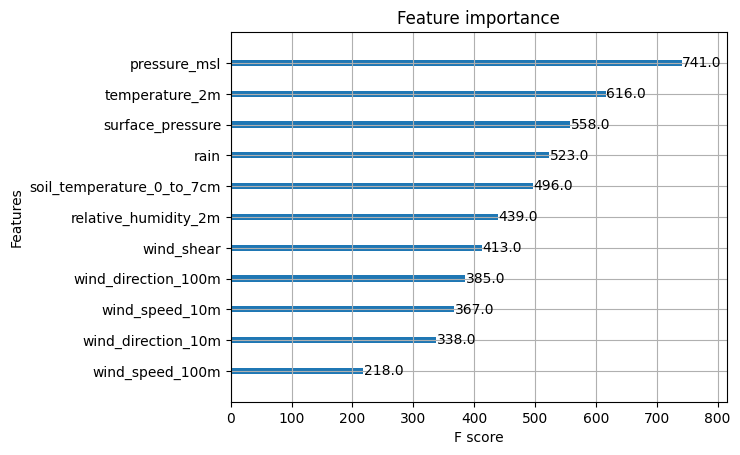

In [33]:
#feature Importance
plot_importance(model)
plt.show()

For tuning the models, log loss could be a better metric to evaluate as it is sensitive to the imbalance and can give a more interpretable metric for meterologists to consider when issuing a warning. 

In [49]:
from sklearn.metrics import log_loss
y_pred_proba = model.predict_proba(X_test)
logloss = log_loss(y_test, y_pred_proba)
print("Log Loss: %.3f" % logloss)

Log Loss: 0.020


#### Parameter Tuning using RandomSearchCV

Random Search is a way for us to test multiple parameters in a model to see what will have the best logloss score and be ideal for making tornado predictions

In [83]:
#regular random search grid
from sklearn.model_selection import RandomizedSearchCV

#parameter grid

param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.5, 0.8, 1],
    'scale_pos_weight': [weight]
}

In [84]:
#do xgboost cv random search with parameter grid with logloss
model=XGBClassifier()
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=5, scoring='neg_log_loss', n_jobs=-1, cv=3, random_state=96)
random_search.fit(X_train, y_train)

#best parameters
print(random_search.best_params_)

#best score
print(random_search.best_score_)

#{'subsample': 1, 'scale_pos_weight': 4581.584507042254, 'max_depth': 9, 'learning_rate': 0.1}
#-0.019873023221179262

{'subsample': 1, 'scale_pos_weight': 4581.584507042254, 'max_depth': 9, 'learning_rate': 0.1}
-0.01915564213890274


In [85]:
#confusion matrix
y_pred = random_search.predict(X_test)
confusion_matrix(y_test, y_pred)

conf_matrix_xgboost=confusion_matrix(y_test, y_pred)
log_loss_xgboost = log_loss(y_test, random_search.predict_proba(X_test))

With XGBoost, we can see that the log loss is lower than the initial model by a bit, and the confusion matrix shows inital classifications are similar to the model as well. 

An issue with this approach is the significantly high number of false positives. These types of probabilties could be misleading to decision makers when issuing a warning, and multiple false alarms could cause the public to not take true alarms seriously. 

We will explore other classification models to see if that can be adjusted

### CatBoost
Another model that should be considered is Catboost. According to recent research from McElfresh et al. Our dataset follows a pattern that suggests catboost could be another model with positive results. The documentation from the paper suggests that this could be good given the emphasis on catagorical variables and the default model requiring less hyperparameter tuning

<div style="display: flex; justify-content: space-between;">
    <div style="flex: 1; text-align: center;">
        <img src="images/modelselection.png" alt="" style="max-width: 50%;">
        <p> </p>
    </div>

</div>
<center>
    <p>Source: <a href="https://arxiv.org/pdf/2305.02997" target="_blank">WhenDoNeural Nets Outperform Boosted Trees on
 Tabular Data?</a></p>
</center>

In [62]:
#import catboost and use initial weight only with log loss score
from catboost import CatBoostClassifier
model = CatBoostClassifier(scale_pos_weight=weight, verbose=False, save_snapshot=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
logloss = log_loss(y_test, model.predict_proba(X_test))
print("Log Loss: %.3f" % logloss)

#confusion matrix
confusion_matrix(y_test, y_pred)


Log Loss: 0.007


array([[1038676,    2272],
       [    122,      94]], dtype=int64)

In [64]:
#f1 score
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print("Weighted F1 Score: %.2f%%" % (weighted_f1 * 100.0))

Weighted F1 Score: 99.87%


#### Parameter Tuning

In [65]:
#catboost tune
from sklearn.model_selection import RandomizedSearchCV

#parameter grid
param_grid = {
    'depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'scale_pos_weight': [weight]
}

#do catboost cv random search with parameter grid with logloss
model=CatBoostClassifier(verbose=False, save_snapshot=False)
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=5, scoring='neg_log_loss', n_jobs=-1, cv=3, random_state=96)
random_search.fit(X_train, y_train)

#best parameters
print(random_search.best_params_)
#best score
print(random_search.best_score_)

#{'scale_pos_weight': 4581.584507042254, 'learning_rate': 0.1, 'depth': 9}
#logloss: -0.0037252820577952663

{'scale_pos_weight': 4581.584507042254, 'learning_rate': 0.1, 'depth': 9}
-0.0037252820577952663


In [240]:
weight=weather_df['tornado'].value_counts()[0]/weather_df['tornado'].value_counts()[1]
weight

#split train test
X = weather_df.drop(columns=['tornado', 'time','county_name', 'location_id'])
y = weather_df['tornado']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=96, stratify=y)

In [251]:
y_test.value_counts()

tornado
0    1040937
1        227
Name: count, dtype: int64

In [252]:
y_train.value_counts()

tornado
0    4163743
1        909
Name: count, dtype: int64

In [233]:
catboost=CatBoostClassifier(scale_pos_weight=weight, verbose=False, save_snapshot=False, learning_rate=0.1, depth=9)
catboost.fit(X_train, y_train)
y_pred = catboost.predict(X_test)
logloss = log_loss(y_test, catboost.predict_proba(X_test))
print("Log Loss: %.3f" % logloss)

#confusion matrix
confusion_matrix(y_test, y_pred)

Log Loss: 0.004


array([[1039930,    1018],
       [    115,     101]], dtype=int64)

In [190]:
#catboost proba value count
y_pred_proba = catboost.predict_proba(X_test)
cat_proba=pd.Series(y_pred_proba[:, 1]).round(2).value_counts().sort_index()


C:\Users\goodm\AppData\Local\Temp\ipykernel_3136\2391142792.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = cat_proba_df.groupby('Bin')['Count'].sum().reset_index()


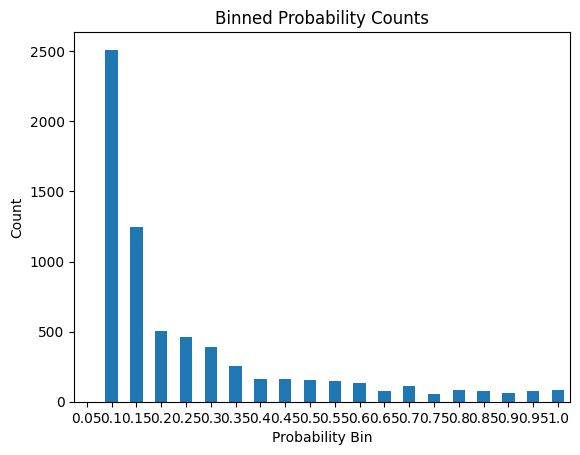

In [200]:
#catproba to dataframe
cat_proba_df=pd.DataFrame(cat_proba).reset_index()
cat_proba_df.columns=['Probability', 'Count']
# Define the bin edges based on the nearest 0.05
bin_edges = np.arange(0, 1.05, 0.05)

# Assign each probability to the nearest bin
cat_proba_df['Bin'] = pd.cut(cat_proba_df['Probability'], bins=bin_edges, right=False, labels=np.round(bin_edges[1:], 2))

# Filter out bins under 0.05
cat_proba_df = cat_proba_df[cat_proba_df['Bin'] >= 0.1]

# Aggregate counts within each bin
binned_data = cat_proba_df.groupby('Bin')['Count'].sum().reset_index()

# Plot the binned data
binned_data.plot.bar(x='Bin', y='Count', rot=0, legend=False)
plt.xlabel('Probability Bin')
plt.ylabel('Count')
plt.title('Binned Probability Counts')
plt.show()

In [86]:
conf_matrix_catboost = np.array([[1039722, 1226],
                        [110, 106]], dtype=np.int64)

log_loss_catboost = .004

## Model Justification



### Ensemble Model
Both models performed very well in certain aspects. XGBoost captured more of the tornado events, but had more false alarms. CatBoost had much less false alarms, but its best model only captured 43% of the test set.

We want to combine these two models using a stacking ensemble method with a logistic regression blender. This should help even out the imbalance between the two models.

<div style="display: flex; justify-content: space-between;">
    <div style="flex: 1; text-align: center;">
        <img src="images/blender_model.png" alt="" style="max-width: 50%;">
        <p> </p>
    </div>

</div>
<center>
    <p>Source: <a href="https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/" target="_blank">Hands on Machine Learning by Aurelien Geron</a></p>
</center>

In [16]:
#read in weather_evetns parquet file
import pandas as pd
weather_df = pd.read_parquet('weather_events.parquet')

In [17]:
#split train test
from sklearn.model_selection import train_test_split
X = weather_df.drop(columns=['tornado', 'time','county_name', 'location_id'])
y = weather_df['tornado']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=96, stratify=y)
weight=weather_df['tornado'].value_counts()[0]/weather_df['tornado'].value_counts()[1]

In [18]:
#best xgboost
xgb=XGBClassifier(scale_pos_weight=weight, max_depth=9, learning_rate=0.1,n_jobs=-1)
#best CatBoost
cat=CatBoostClassifier(scale_pos_weight=weight, depth=9, learning_rate=0.1, verbose=False, save_snapshot=False)

#blender
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
blender=make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='saga',n_jobs=-1, max_iter=1000))

In [ ]:
from sklearn.ensemble import StackingClassifier

ensemble_model=StackingClassifier(estimators=[('xgb', xgb),
                                             ('cat', cat)], 
                                             final_estimator=blender,
                                             cv=3)

In [72]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print("Weighted F1 Score: %.2f%%" % (weighted_f1 * 100.0))

#log loss
y_pred_proba = ensemble_model.predict_proba(X_test)
logloss = log_loss(y_test, y_pred_proba)
print("Log Loss: %.3f" % logloss)

#confusion matrix
confusion_matrix(y_test, y_pred)

Weighted F1 Score: 96.12%
Log Loss: 1.568


array([[963642,  77306],
       [     8,    208]], dtype=int64)

**This method of doing stacked ensemble with logistic regression has too many false positives and a much higher log loss. I decided to use an xgboost as the blender and do outside sklearn for faster computation and enable early stopping**

In [214]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import numpy as np

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# Define the base models
xgb = XGBClassifier(scale_pos_weight=weight, max_depth=9, learning_rate=0.1, n_jobs=-1, early_stopping_rounds=50)
cat = CatBoostClassifier(scale_pos_weight=weight, depth=9, learning_rate=0.1, early_stopping_rounds=50, save_snapshot=False)

# Fit the base models
xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)
cat.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=True)

# Generate predictions for the training and validation sets
xgb_train_pred = xgb.predict_proba(X_train)[:, 1]
cat_train_pred = cat.predict_proba(X_train)[:, 1]

xgb_test_pred = xgb.predict_proba(X_test)[:, 1]
cat_test_pred = cat.predict_proba(X_test)[:, 1]

# Stack predictions as new features
train_stack = np.column_stack((xgb_train_pred, cat_train_pred))
valid_stack = np.column_stack((xgb_test_pred, cat_test_pred))

# Prepare the data for XGBoost blender
blender = XGBClassifier(scale_pos_weight=weight, max_depth=10, n_jobs=-1, early_stopping_rounds=50)

# Train XGBoost as the blender on the stacked features
blender.fit(train_stack, y_train, eval_set=[(valid_stack, y_test)], verbose=True)

# Generate predictions for the validation set using the blender
ensemble_pred_proba = blender.predict_proba(valid_stack)[:, 1]
ensemble_pred = (ensemble_pred_proba > 0.5).astype(int)

[0]	validation_0-logloss:0.61328
[1]	validation_0-logloss:0.54790
[2]	validation_0-logloss:0.49401
[3]	validation_0-logloss:0.44783
[4]	validation_0-logloss:0.40849
[5]	validation_0-logloss:0.37489
[6]	validation_0-logloss:0.34612
[7]	validation_0-logloss:0.32089
[8]	validation_0-logloss:0.29753
[9]	validation_0-logloss:0.27779
[10]	validation_0-logloss:0.25912
[11]	validation_0-logloss:0.24326
[12]	validation_0-logloss:0.22842
[13]	validation_0-logloss:0.21496
[14]	validation_0-logloss:0.20254
[15]	validation_0-logloss:0.19200
[16]	validation_0-logloss:0.18270
[17]	validation_0-logloss:0.17226
[18]	validation_0-logloss:0.16509
[19]	validation_0-logloss:0.15863
[20]	validation_0-logloss:0.15170
[21]	validation_0-logloss:0.14471
[22]	validation_0-logloss:0.13846
[23]	validation_0-logloss:0.13244
[24]	validation_0-logloss:0.12716
[25]	validation_0-logloss:0.12251
[26]	validation_0-logloss:0.11801
[27]	validation_0-logloss:0.11250
[28]	validation_0-logloss:0.10832
[29]	validation_0-loglos

In [215]:
ensemble_pred = (ensemble_pred_proba > .9).astype(int)

log_loss_value = log_loss(y_test, ensemble_pred_proba)
conf_matrix = confusion_matrix(y_test, ensemble_pred)

print("Log Loss: %.3f" % log_loss_value)
print("Confusion Matrix:")
print(conf_matrix)

conf_matrix_stack = confusion_matrix(y_test, ensemble_pred)
log_loss_stack = log_loss(y_test, ensemble_pred_proba)

Log Loss: 0.021
Confusion Matrix:
[[1037076    3861]
 [     98     129]]


In [181]:
#list of ensemble_pred_proba value counts
pd.Series(ensemble_pred_proba).value_counts().sort_index()


0.0003    1037069
0.0026        105
0.9880         30
0.9900        174
0.9903         37
0.9916        141
0.9923        392
0.9931        112
0.9941        269
0.9944         25
0.9947         60
0.9950        521
0.9954        752
0.9955         67
0.9976       1410
Name: count, dtype: int64

## Results and Insights

- The stacked ensemble model with the logistic regression blender had the worst all around results with a log loss score over 1

- While almost all of the tornados in the test set were predicted correctly at a 50% threshold, this had over 77k false positives

- With our purpose being maxmizing true predictions, limiting false positives, the best model for this use case is the xgboost model with a log loss of .02, correctly predicting 67% of the tornados, and having a false postive amount of 10,000

- Catboost tuned could also be good, but it missed predicting 50% of the tornados, but had a very low false positive amount of under 2k. 

- To attempt another stacked ensemble and keep the benefit of gradient boosting, an **XGBoost blender** was applied with the data weight.

**As we can see this was an improvement over the logistic regression blender, but the overall log loss was very close to the XGBoost model, the predictions with the ensemble were very close to binary, either close 0 or .99. As CatBoost had the best logloss, I decided to explore that model further in enhancements**



## Model Compare, log loss and 50% threshold

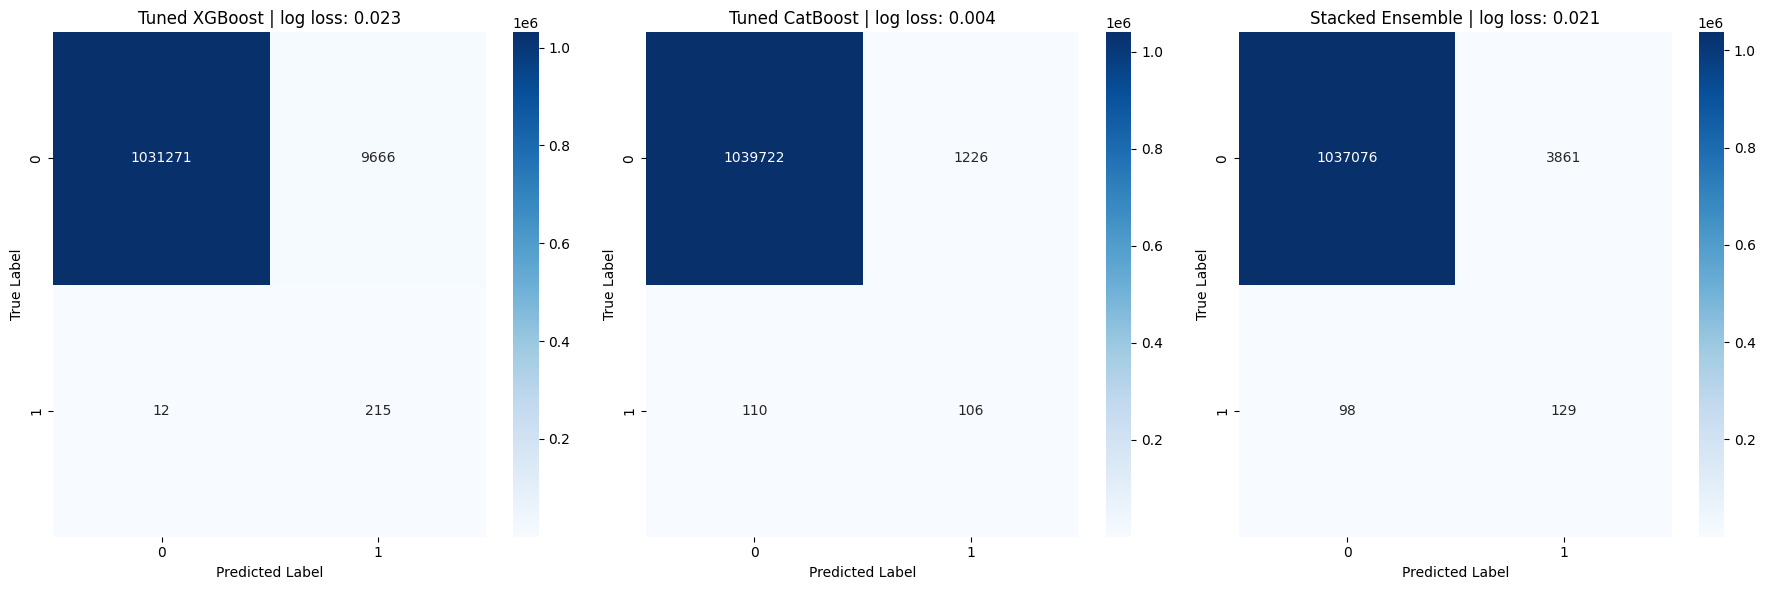

In [228]:
import matplotlib.pyplot as plt

conf_matrix_cat = ...

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot = top left
sns.heatmap(conf_matrix_xgboost, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Tuned XGBoost | log loss: {:.3f}'.format(log_loss_xgboost))

plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot = top middle
sns.heatmap(conf_matrix_catboost, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Tuned CatBoost | log loss: {:.3f}'.format(log_loss_catboost))

plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot = top right
sns.heatmap(conf_matrix_stack, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Stacked Ensemble | log loss: {:.3f}'.format(log_loss_stack))

plt.tight_layout()
plt.show()

## Threshold Adjustment

This model can be used with Iowa weather sensor data to determine the liklihood a tornado occuring in a given county, when officals can use the predictions to set their own threshold of comfort for issuing warnings. The default on the libaries is 50%. However when we look at the distributions of probabilities, most positive results are above .9.

A new threshold should be set for making binary decisions regarding issuing warnings. We want to optimize the best combination of capturing all the positive events while limiting our false alarms. The function below shows how we can find the best combination of precision and recall for our 2 base models. 

In [219]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, log_loss, confusion_matrix

def optimize_threshold_with_plot(model, X_test, y_test, start=0.0, end=1.0, step=0.01):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    thresholds = np.arange(start, end, step)
    precisions = []
    recalls = []
    log_losses = []
    
    best_threshold = 0.5
    best_precision = 0
    best_recall = 0
    best_log_loss = float('inf')
    best_conf_matrix = None
    best_combined_metric = 0
    
    for threshold in thresholds:
        y_pred = (y_pred_proba > threshold).astype(int)
        
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        log_loss_value = log_loss(y_test, y_pred_proba)
        
        precisions.append(precision)
        recalls.append(recall)
        log_losses.append(log_loss_value)
        
        # Combined metric: sum of precision and recall
        combined_metric = precision + recall
        
        if combined_metric > best_combined_metric:
            best_threshold = threshold
            best_precision = precision
            best_recall = recall
            best_log_loss = log_loss_value
            best_conf_matrix = confusion_matrix(y_test, y_pred)
            best_combined_metric = combined_metric
    
    print(f"Optimal Threshold: {best_threshold:.3f}")
    print(f"Precision: {best_precision:.3f}")
    print(f"Recall: {best_recall:.3f}")
    print(f"Log Loss: {best_log_loss:.3f}")
    print("Confusion Matrix:")
    print(best_conf_matrix)
    
    # Plotting the metrics
    plt.figure(figsize=(7, 4))
    
    plt.plot(thresholds, precisions, label='Precision', color='b')
    plt.plot(thresholds, recalls, label='Recall', color='r')
    plt.ylabel('Score')
    plt.title('Precision and Recall vs. Decision Threshold')
    # Add a dotted line for best threshold
    plt.axvline(x=best_threshold, color='k', linestyle='--')
    plt.legend()
    


    plt.show()
    
    return best_threshold, best_precision, best_recall, best_log_loss, best_conf_matrix


In [272]:
#split train test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=96, stratify=y)

c:\Users\goodm\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Optimal Threshold: 0.970
Precision: 0.435
Recall: 0.718
Log Loss: 0.023
Confusion Matrix:
[[1040725     212]
 [     64     163]]


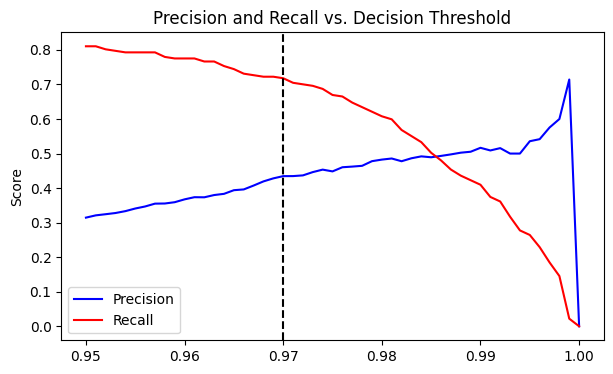

(0.97,
 0.43466666666666665,
 0.7180616740088106,
 0.023216033867168435,
 array([[1040725,     212],
        [     64,     163]], dtype=int64))

In [273]:
optimize_threshold_with_plot(xgb, X_test, y_test, start=.95, end=1, step=0.001)

c:\Users\goodm\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Optimal Threshold: 0.999
Precision: 0.500
Recall: 0.053
Log Loss: 0.004
Confusion Matrix:
[[1040925      12]
 [    215      12]]


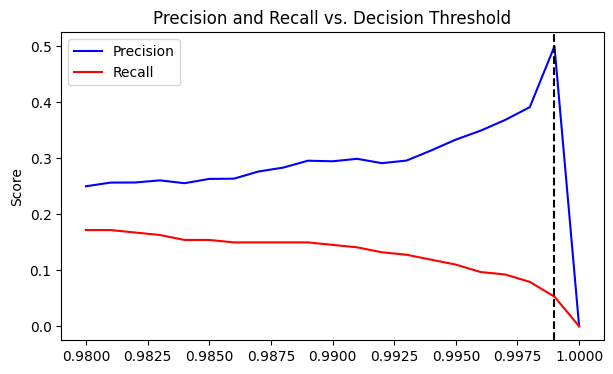

In [274]:
best_threshold, best_precision, best_recall, best_log_loss, best_conf_matrix = optimize_threshold_with_plot(catboost, X_test, y_test, start=0.98, end=1.0, step=0.001)

c:\Users\goodm\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Optimal Threshold: 0.994
Precision: 0.884
Recall: 0.837
Log Loss: 0.003
Confusion Matrix:
[[1040912      25]
 [     37     190]]


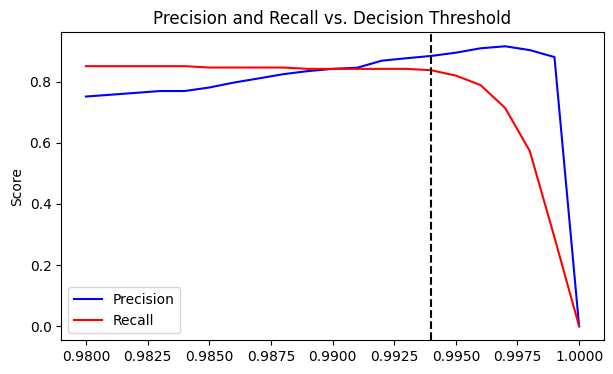

In [225]:
best_threshold, best_precision, best_recall, best_log_loss, best_conf_matrix = optimize_threshold_with_plot(catboost, X_test, y_test, start=0.98, end=1.0, step=0.001)

As we can see, using the tuned version of catboost with a threshold set of .994 returns a great model. Better than the ensemble alone or xgboost

We are able to capture 83% of tornados, only have a false positve amount of 25!

## Future Considerations


- Spatial and Time component, use LSTM
- Expand paramter tuning and weight adjustments using Spark or other distrubuted computing tools to handle computational obstacles
- Neural Network adjusting weights depending on results of others
- Apply other metrics like autoregressors and weather sensor gradience to measure signals related to weather time series
- Incorporate spatial components into the model like county and distance to county with higher risk
- Dist of prob

# Model Output

In [203]:
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb, file)

cat.save_model('cat_model.cbm')

with open('blender_model.pkl', 'wb') as file:
    pickle.dump(blender, file)

print("Models saved: xgb_model.pkl, cat_model.cbm, blender_model.pkl")

Models saved: xgb_model.pkl, cat_model.cbm, blender_model.pkl


In [73]:
#export pickle file for model
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(ensemble_model, f)

#### Feature Importance

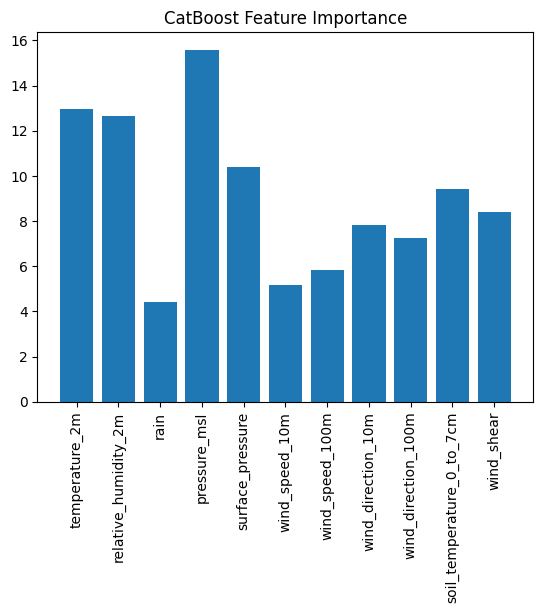

In [83]:
#add X_train columns as labels
plt.bar(X_train.columns, cat_importance)
plt.xticks(rotation=90)
plt.title("CatBoost Feature Importance")
plt.show()

In [ ]:
#feature importance with stacked model
xgb.fit(X_train, y_train)
xgb_importance = xgb.feature_importances_
plt.bar(range(len(xgb_importance)), xgb_importance)
plt.title("XGBoost Feature Importance")
plt.show()

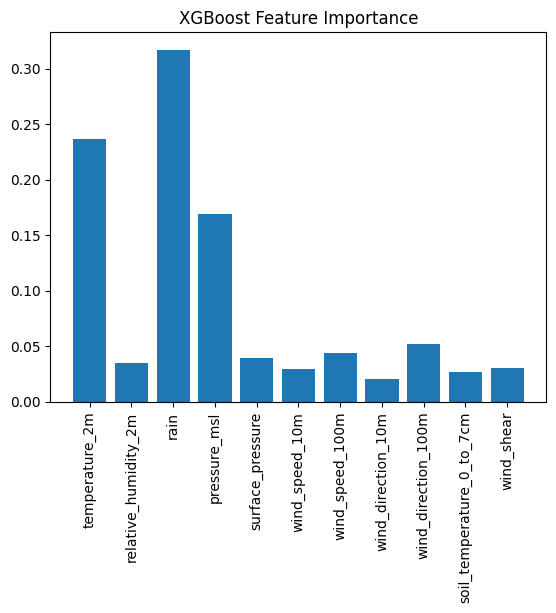

In [79]:
X_train.columns
#use columns as plot labels
plt.bar(X_train.columns, xgb_importance)
plt.xticks(rotation=90)
plt.title("XGBoost Feature Importance")
plt.show()